<h1 id="Predict-on-Google-Cloud-ML-Engine">Predict on Google Cloud ML Engine</h1>

<p>tags: kaggle, digit, mnist, google cloud, ml-engline, ai-platform, predict, online, batch, json</p>

<p><a href="https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts/" target="_blank">https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts</a></p>

<p><a href="https://github.com/googledatalab/notebooks/blob/991fba5b26b4cb2651e7d7c50ab65afeb5761219/samples/ML%20Toolbox/Regression/Census/5%20Service%20Predict.ipynb">https://github.com/googledatalab/notebooks/blob/991fba5b26b4cb2651e7d7c50ab65afeb5761219/samples/ML%20Toolbox/Regression/Census/5%20Service%20Predict.ipynb</a></p>


In [1]:
import os
import shutil
import gcsfs
from datetime import datetime

import json, codecs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
PROJECT = "kaggle________" # REPLACE WITH YOUR PROJECT ID
BUCKET = "kaggle________" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
TFVERSION = "1.13"


os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = TFVERSION  # Tensorflow version

In [ ]:
!gcloud auth list
!gcloud config set project $PROJECT
!gcloud config set compute/region $REGION
!gcloud config list project
#!gcloud compute instances list

In [4]:
#deployed model
MODEL_NAME='kaggle_digit_cnn'
MODEL_VERSION="t01"


## Create input test dataset 

In [5]:
# create json file from test iamges for predict

HEIGHT = 28
WIDTH = 28

#### input test data

test = pd.read_csv('../data/test.csv')
test_images = test.to_numpy().astype('float32')/255.0

test_images.shape


(28000, 784)

In [45]:
len(test_images)

28000

In [46]:
IMGNO=len(test_images);
JSON_DATA="../data/test_allimg.json"
JSON_DATA_5img="../data/test_5img.json" 

with open(JSON_DATA, "w") as file:
    for i in range(IMGNO):
        jsondata = {"image": test_images[i].reshape([HEIGHT,WIDTH]).tolist()}
        file.write(json.dumps(jsondata) + '\n')

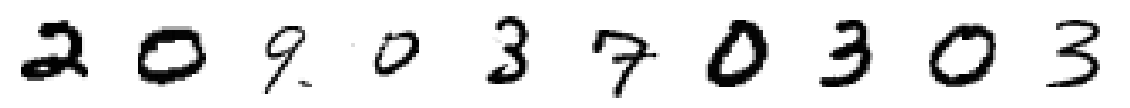

In [47]:
IMGNO=10
plt.figure(figsize=(20,5))
for i in range(IMGNO):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.axis('off')


## Online prediction 

In [5]:
JSON_DATA_5img="../data/test_5img.json" 

In [6]:
!gcloud ai-platform predict \
    --model=$MODEL_NAME \
    --version=$MODEL_VERSION \
    --json-instances=$JSON_DATA_5img 

CLASS_IDS  PROBABILITIES
2          [7.093776588362743e-08, 2.2788258036143816e-07, 0.9999858140945435, 8.286970683002437e-07, 2.687536193590745e-09, 2.9779695376319637e-10, 5.848130313346189e-11, 1.2598188732226845e-05, 3.0776192261328106e-07, 3.1510822395830473e-08]
0          [0.9998999834060669, 1.9269327822257765e-06, 5.584812242886983e-06, 4.5135443826893606e-08, 7.422779901844478e-08, 5.708746812160825e-06, 5.505998615262797e-06, 6.578650209121406e-05, 1.2466653060982935e-06, 1.4125875168247148e-05]
9          [2.2094129690231057e-06, 5.80093364987988e-06, 1.4805370938120177e-06, 0.00014728045789524913, 0.0003923723706975579, 1.4150448805594351e-05, 1.2030977103449914e-08, 0.0002630635572131723, 0.0007692530634813011, 0.9984044432640076]
0          [0.7255468368530273, 0.0007831885595805943, 0.04517584294080734, 0.002723017241805792, 0.00012076569691998884, 0.0006411412032321095, 0.00045932954526506364, 0.013404740020632744, 0.022294865921139717, 0.18885022401809692]
3          

## Batch prediction

In [7]:
INPDIR='gs://'+BUCKET+'/digit/data/test_allimg.json'
OUTDIR='gs://'+BUCKET+'/digit/data/prediction'


#!gsutil cp $JSON_DATA $INPDIR

In [10]:
JOBNAME='pred_cnnt01_allimg_'+datetime.now().strftime("%Y%m%d_%H%M%S")

print("Jobname: ",JOBNAME)


Jobname:  pred_cnnt01_allimg_20190904_182610


In [12]:
!gcloud ai-platform jobs submit prediction $JOBNAME \
    --model=$MODEL_NAME \
    --version=$MODEL_VERSION \
    --data-format=TEXT \
    --region=$REGION \
    --input-paths=$INPDIR \
    --output-path=$OUTDIR

jobId: pred_cnnt01_allimg_20190904_182610
state: QUEUED


Job [pred_cnnt01_allimg_20190904_182610] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe pred_cnnt01_allimg_20190904_182610

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs pred_cnnt01_allimg_20190904_182610


In [ ]:
!gsutil ls $OUTDIR

In [ ]:
#download multiple parts of the prediction 
PRED_LOCAL="../data/"

for i in range(8):
    PRED_CLOUD = OUTDIR + '/prediction.results-0000'+str(i)+'-of-00008'
    !gsutil cp $PRED_CLOUD $PRED_LOCAL

In [17]:
pred=[]
for j in range(8):
    PRED_LOCAL='../data/prediction.results-0000'+str(j)+'-of-00008'
    print('reading ', PRED_LOCAL)
    data = [json.loads(line) for line in open(PRED_LOCAL, 'r')]
    
    for i in range(len(data)):
        pred.append(data[i]['class_ids'])


reading  ../data/prediction.results-00000-of-00008
reading  ../data/prediction.results-00001-of-00008
reading  ../data/prediction.results-00002-of-00008
reading  ../data/prediction.results-00003-of-00008
reading  ../data/prediction.results-00004-of-00008
reading  ../data/prediction.results-00005-of-00008
reading  ../data/prediction.results-00006-of-00008
reading  ../data/prediction.results-00007-of-00008


In [21]:
np.shape(pred)

(28000,)

In [22]:
pred[:10]

[2, 0, 9, 0, 3, 7, 0, 3, 0, 3]

In [23]:
output = pd.DataFrame({ 'ImageId' : np.arange(len(pred))+1, 'Label': pred })
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
#output.to_csv('data/sub_digit_cnn_estimator_v03_gcp_30ep.csv', index = False)

<h2 id="Next-steps">Next steps</h2>

<p>&nbsp;</p>

<ol>
	<li>recreat tf record&nbsp;<a href="https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts/create_records.py" target="_blank">https://github.com/GoogleCloudPlatform/cloudml-dist-mnist-example/blob/master/scripts/create_records.py</a></li>
</ol>
